<a href="https://colab.research.google.com/github/KwonYN/TIL/blob/master/PYTHON/TENSORFLOW2/10_01_DP_part1_7_kyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **심화 실습 10-1 : Modern CNN**

## **Import Module**

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
#import tensorflow.keras as keras
from tensorflow.keras import models, datasets
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.layers import MaxPool2D, MaxPool1D
from tensorflow.keras.layers import Dropout, BatchNormalization

import numpy as np
import matplotlib.pyplot as plt

tf.__version__

TensorFlow 2.x selected.


'2.0.0'

## **DataSet**

### Load

In [0]:
#img_dataset = datasets.fashion_mnist
img_dataset = datasets.cifar10

(x_train, y_train), (x_test, y_test) = img_dataset.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

### Preprocessing

In [0]:
# for fashion_mnist or mnist dataset
# Add a channels dimension
#x_train = x_train[..., tf.newaxis] #(28,28,1)
#x_test = x_test[..., tf.newaxis]

# Converts class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 10), (10000, 10))

## DataSet: G-drive에서 압축된 zip파일을 복사해 와서 처리하기

### 1.0 G-drive mount

In [0]:
# Data size가 클때는 옮겨와서 처리하는 것이 좋음
# *Google* drive mount
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.0.0 import aidlutils

In [0]:
import sys
sys.path.append('/content/drive/Shared drives/scsa_2019_e/aidl-utils/basic')

from aidlutils import show_batch, check_dir, check_image

### 1.1 unzip the file

In [0]:
# check the images have been extracted
# extract images on colab drive
!tar -xf /content/drive/Shared\ drives/scsa_2019_e/z_data/flower_photos.tgz

### 1.2 check images

In [0]:
# check_dir() 사용할 수 있도록 준비
import pathlib

# set data_dir
#"/content"가 나의 colab의 시작
data_dir_cwd = pathlib.Path('/content/flower_photos')

In [0]:
# check_dir()로 폴더명과 이미지 숫자 확인
image_count_cwd, CLASS_NAMES_cwd = check_dir(data_dir_cwd)

class_num = len(CLASS_NAMES_cwd)
print('image_count: {}\nclasses: {}'.format(image_count_cwd, CLASS_NAMES_cwd))

image_count: 3670
classes: ['tulips' 'dandelion' 'roses' 'daisy' 'sunflowers']


In [0]:
# check_image()로 이미지 두장씩 확인 
#check_image(data_dir_cwd, CLASS_NAMES_cwd)

### 1.3 `ImageDataGenerator()`사용하기

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


(array([[[[0.70980394, 0.7372549 , 0.70980394],
          [0.7176471 , 0.7372549 , 0.7137255 ],
          [0.73333335, 0.75294125, 0.7294118 ],
          ...,
          [0.6627451 , 0.83921576, 0.9921569 ],
          [0.6666667 , 0.8431373 , 0.9725491 ],
          [0.654902  , 0.8313726 , 0.95294124]],
 
         [[0.73333335, 0.77647066, 0.74509805],
          [0.7372549 , 0.7803922 , 0.7490196 ],
          [0.74509805, 0.7843138 , 0.75294125],
          ...,
          [0.6862745 , 0.8352942 , 0.87843144],
          [0.7019608 , 0.83921576, 0.854902  ],
          [0.6862745 , 0.81568635, 0.8352942 ]],
 
         [[0.7568628 , 0.77647066, 0.7490196 ],
          [0.74509805, 0.76470596, 0.7372549 ],
          [0.74509805, 0.76470596, 0.7372549 ],
          ...,
          [0.65882355, 0.7568628 , 0.67058825],
          [0.6431373 , 0.7411765 , 0.627451  ],
          [0.6431373 , 0.73333335, 0.61960787]],
 
         ...,
 
         [[0.68235296, 0.6431373 , 0.5019608 ],
          [0.67058

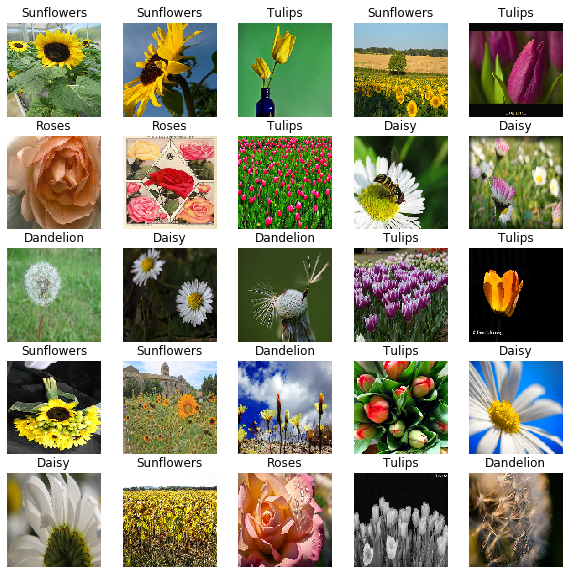

In [0]:
# image generator 생성
# 1./255 : convert in range [0,1]
image_generator_cwd = (
    tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2, 
                                                    rescale=1./255))

# image generator에 폴더path와 폴더명들을 지정하여 data set을 준비
train_data_gen_cwd = image_generator_cwd.flow_from_directory(
                        directory=str(data_dir_cwd),
                        #batch_size=32,
                        shuffle=True,
                        target_size=(112, 112),
                        classes = list(CLASS_NAMES_cwd),
                        subset='training'
                        )
test_data_gen_cwd = image_generator_cwd.flow_from_directory(
                        directory=str(data_dir_cwd),
                        #batch_size=32,
                        shuffle=True,
                        target_size=(112, 112),
                        classes = list(CLASS_NAMES_cwd),
                        subset='validation'
                        )

# 준비된 data set의 일부를 확인
show_batch(train_data_gen_cwd, CLASS_NAMES_cwd)


## **Model**

### Define

### Model_A define: Dropout 사용 model

In [0]:
import tensorflow.keras.regularizers as regularizers

# L1 regularization: 0.001  (0.01 ~ 0.0001)
#model.add(Conv2D(128, 3, padding='same', activation='relu',
#                 activity_regularizer=regularizers.l1(0.001)))
# L2 regularization: 0.01 (0.1 ~ 0.001)
#model.add(Conv2D(128, 3, padding='same', activation='relu',
#                 activity_regularizer=regularizers.l2(0.01)))

# DO: rate: 0.1 ~ 0.5
#model.add(Dropout(rate=0.3))
# BN: momentum: 0.7 ~ 0.99
#model.add(BatchNormalization(momentum=0.8))

def model_cnn_basic():
  model = models.Sequential()
  # conv 1
  model.add(Conv2D(64,3,padding='same',activation='relu',input_shape=(112,112,3), activity_regularizer=regularizers.l2(0.01)))  # , activity_regularizer=regularizers.l2(0.01)
  model.add(BatchNormalization(momentum=0.85))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

  # conv 2
  model.add(Conv2D(128, 3, padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=0.85))
  model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
  model.add(Dropout(rate=0.2))

  # conv 3
  model.add(Conv2D(256, 3, padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=0.85))
  model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))

  # conv 4
  model.add(Conv2D(64, 3, padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=0.85))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

  # Dense layers
  model.add(Flatten(name='flatten'))
  model.add(Dense(class_num, activation='softmax', name='dense_10'))

  return model

model_basic = model_cnn_basic()

model_basic.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 27, 27, 128)       0

### Compile

In [0]:
model_basic.compile(optimizer='adam',
              #loss='sparse_categorical_crossentropy',
              loss='categorical_crossentropy',
              metrics=['acc'])

### Fit

In [0]:
batch_n = 128
epoch_n = 100

Epoch 20/20
60000/60000 [==============================] - 5s 80us/sample - loss: 0.0276 - accuracy: 0.9911
CPU times: user 1min 7s, sys: 30.2 s, total: 1min 38s   
Wall time: 1min 40
(@Notebook Setting/GPU)

In [0]:
%%time
history_basic = model_basic.fit_generator(train_data_gen_cwd,
                                          epochs=epoch_n,
                                          validation_data=test_data_gen_cwd
                        )

Epoch 1/100
92/92 [==============================] - 21s 232ms/step - loss: 7.3985 - acc: 0.5196 - val_loss: 1.2947 - val_acc: 0.5390
Epoch 2/100
92/92 [==============================] - 19s 205ms/step - loss: 1.1279 - acc: 0.6237 - val_loss: 1.0837 - val_acc: 0.6320
Epoch 3/100
92/92 [==============================] - 19s 206ms/step - loss: 0.8894 - acc: 0.6996 - val_loss: 1.1954 - val_acc: 0.6170
Epoch 4/100
92/92 [==============================] - 19s 205ms/step - loss: 0.8056 - acc: 0.7363 - val_loss: 1.1825 - val_acc: 0.6279
Epoch 5/100
92/92 [==============================] - 19s 206ms/step - loss: 0.6617 - acc: 0.7853 - val_loss: 1.1950 - val_acc: 0.6443
Epoch 6/100
92/92 [==============================] - 19s 206ms/step - loss: 0.5201 - acc: 0.8340 - val_loss: 1.0676 - val_acc: 0.6881
Epoch 7/100
92/92 [==============================] - 19s 205ms/step - loss: 0.4458 - acc: 0.8639 - val_loss: 1.3588 - val_acc: 0.6265
Epoch 8/100
92/92 [==============================] - 19s 204ms

Epoch 20/20
60000/60000 [==============================] - 4s 73us/sample - loss: 2.1958e-04 - accuracy: 1.0000
CPU times: user 1min 1s, sys: 25.2 s, total: 1min 26s   
Wall time: 1min 27s (@Notebook Setting/GPU)

In [0]:
%%time
history_basic = model_basic.fit_generator(train_data_gen_cwd,
                                          epochs=epoch_n,
                                          validation_data=test_data_gen_cwd
                        )

## **Analysis**

In [0]:
model_basic.evaluate(x_test, y_test, verbose=2)

In [0]:
print(np.max(history_basic.history['val_acc']))

0.7116  
0.7257  
0.7268

### Plot

In [0]:
history_basic.history.keys()

In [0]:
loss = history_basic.history['loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.title('Validation Loss')
plt.semilogy(epochs, history_basic.history['val_loss'], 'b', label='CNN')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.0, 0.6])
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.title('Validation Accuray')
plt.semilogy(epochs, history_basic.history['val_acc'], 'b', label='CNN')
plt.grid(True)
plt.ylabel('Accuracy')
plt.ylim([0.5, 0.9])
plt.legend(loc='best')
plt.show()

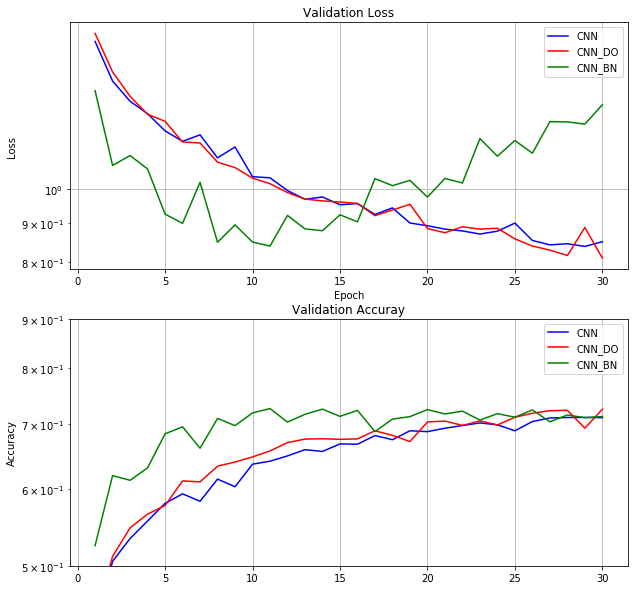

## **실습 과제**

### 과제1 성능 개선을 위해서 다양한 실험이 필요해 보인다.
#### -- Layer / Feature map 숫자 변경, 
#### -- dropout / batch normalization 위치 및 숫자 변경,
#### -- batch size, epoch 변경을 통해 모델을 최적화 해 보자 
#### -- 조별로 최고의 성능을 달성한 모델의 구조와 주요 hyper-parameter 및 최고 val_acc를 기록하자 : 
